# Text Classification of StackOverflow using TF-IDF Vectors

In [1]:
import sys
import os
from os import pardir, getcwd
from os.path import join, abspath
PARENT_DIRECTORY = abspath(join(getcwd(), pardir))
sys.path.insert(0, PARENT_DIRECTORY)

import warnings
import sklearn.exceptions
import talos as ta
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


from definitions import TALOS_DIR
from app.preprocessing import load_dataset,preprocess_data
from app.models import load_model


Using TensorFlow backend.


## Preprocessing for the loaded Dataset
1. Remove *punctuation* characters
2. Remove *stopwords*
3. Remove *links*
4. Remove *Numbers*
5. Format into *lowercase*

In [2]:
data = load_dataset(load_from_pickle=True)
Classes = list(data['tags'].value_counts().index)
Nclasses = len(Classes)
print(data['tags'].value_counts())

sql              2000
ruby-on-rails    2000
android          2000
angularjs        2000
asp.net          2000
c                2000
c#               2000
c++              2000
css              2000
html             2000
ios              2000
iphone           2000
java             2000
javascript       2000
jquery           2000
mysql            2000
objective-c      2000
php              2000
python           2000
.net             2000
Name: tags, dtype: int64


## MLP classifier in Keras using not standardized tf*idf features

 ### Hyper parameter tuning for the **tf-idf** model

In [4]:
# 70% Train & 10% HeldOut & 20% Test
model_data_tf = preprocess_data(data, 'tags', 'post',
                                input_ins='as_tf_idf',
                                cv_split_full=0.2,
                                cv_split_dev=0.125)


In [6]:
'''Use the test filename if ypu don't want to delete
    # your current logs from the previous run.'''
TALOS_TF_LOG_FILENAME = 'talos_tf_log_test'

#--- In case of production logs comment out the below filename
#TALOS_TF_LOG_FILENAME = 'talos_tf_log'
talos_tf_log_pathname = os.path.join(TALOS_DIR, TALOS_TF_LOG_FILENAME)

###### Production configuration
tf_idf_model_config = {
    'visualize_proccess': [False],
    'first_neuron': [64, 128],  # First Layer
    'activation': ['relu', 'tanh'],
    'dropout': [0.2, 0.6],
    'number_of_hidden_layers': [1, 2],
    'shapes':['funnel'],
    'epochs': [15, 20],
    'batch_size': [32, 64],
    'model_type': ['keras_tf_idf_model'],
}

history_model_tf_idf = ta.Scan(model_data_tf['x_train'],
                               model_data_tf['y_train'],
                               x_val=model_data_tf['x_train_dev'],
                               y_val=model_data_tf['y_train_dev'],
                               model=load_model,
                               params=tf_idf_model_config,
                               grid_downsample=0.1,
                               print_params=True,
                               seed=(123),
                               dataset_name=talos_tf_log_pathname
                               )



  0%|          | 0/6 [00:00<?, ?it/s]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.6, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 20, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}



 17%|█▋        | 1/6 [01:19<06:36, 79.23s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 15, 'batch_size': 32, 'model_type': 'keras_tf_idf_model'}



 33%|███▎      | 2/6 [02:18<04:52, 73.15s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 15, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}



 50%|█████     | 3/6 [03:17<03:27, 69.05s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 20, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}



 67%|██████▋   | 4/6 [04:35<02:23, 71.76s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.6, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 15, 'batch_size': 32, 'model_type': 'keras_tf_idf_model'}



 83%|████████▎ | 5/6 [06:13<01:19, 79.70s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 15, 'batch_size': 32, 'model_type': 'keras_tf_idf_model'}



100%|██████████| 6/6 [07:54<00:00, 86.07s/it]

    Finds the best model configuration set for the TF-IDF, after the Talos Scanning.

In [7]:
report_tf = ta.Reporting(history_model_tf_idf)
best_model_idx = report_tf.data['val_f1'].idxmax()
best_model_params = report_tf.data.loc[best_model_idx].to_dict()
best_model_params

{'round_epochs': 15,
 'val_loss': 0.5641586499214173,
 'val_f1': 0.7918524127006531,
 'val_categorical_accuracy': 0.823,
 'loss': 0.3200537195631436,
 'f1': 0.7671789708137512,
 'categorical_accuracy': 0.8953214285714286,
 'visualize_proccess': 'False',
 'first_neuron': 128,
 'activation': 'tanh',
 'dropout': 0.6,
 'number_of_hidden_layers': 1,
 'shapes': 'funnel',
 'epochs': 15,
 'batch_size': 32,
 'model_type': 'keras_tf_idf_model'}

    Trains and fit the MLP Network  using the best selected features.

In [8]:
model_tf_history, model_tf = load_model(model_data_tf['x_train'],
                                        model_data_tf['y_train'],
                                        model_data_tf['x_train_dev'],
                                        model_data_tf['y_train_dev'],
                                        best_model_params)

### Visualize Model History Scores

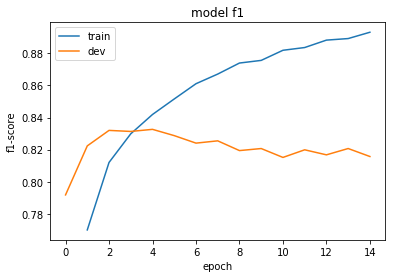

KeyError: 'val_'

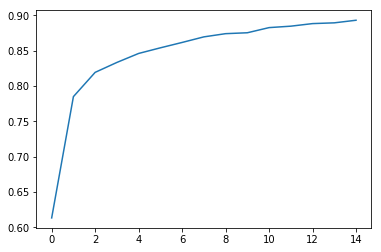

In [9]:
from app.visualization import plot_history_metrics
import matplotlib.pylab as plt

%matplotlib inline
plot_history_metrics(history_obj=model_tf_history)

### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [10]:
score_tf = model_tf.evaluate(model_data_tf['x_test'],
                             model_data_tf['y_test'],
                             batch_size=best_model_params['batch_size'],
                             verbose=1)

print('\nTest f1: %.4f' % (score_tf[1]))
print('\nTest categorical accuracy: %.4f'% (score_tf[2]))

8000/8000 [==============================] - 0s 49us/step

Test f1: 0.8041

Test categorical accuracy: 0.7976


### Visualize Prediction Perfomance of **non-standardized** TF-IDF  model

--------------------------------------------------------------------------------
Accuracy Score: 79.76%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.685     0.662     0.673       400
           1      0.925     0.900     0.913       400
           2      0.977     0.968     0.972       400
           3      0.788     0.770     0.779       400
           4      0.844     0.880     0.862       400
           5      0.599     0.660     0.628       400
           6      0.826     0.792     0.809       400
           7      0.847     0.828     0.837       400
           8      0.645     0.733     0.686       400
           9      0.674     0.605     0.638       400
          10      0.661     0.677     0.669       400
          11      0.836     0.855     0.845       400
       

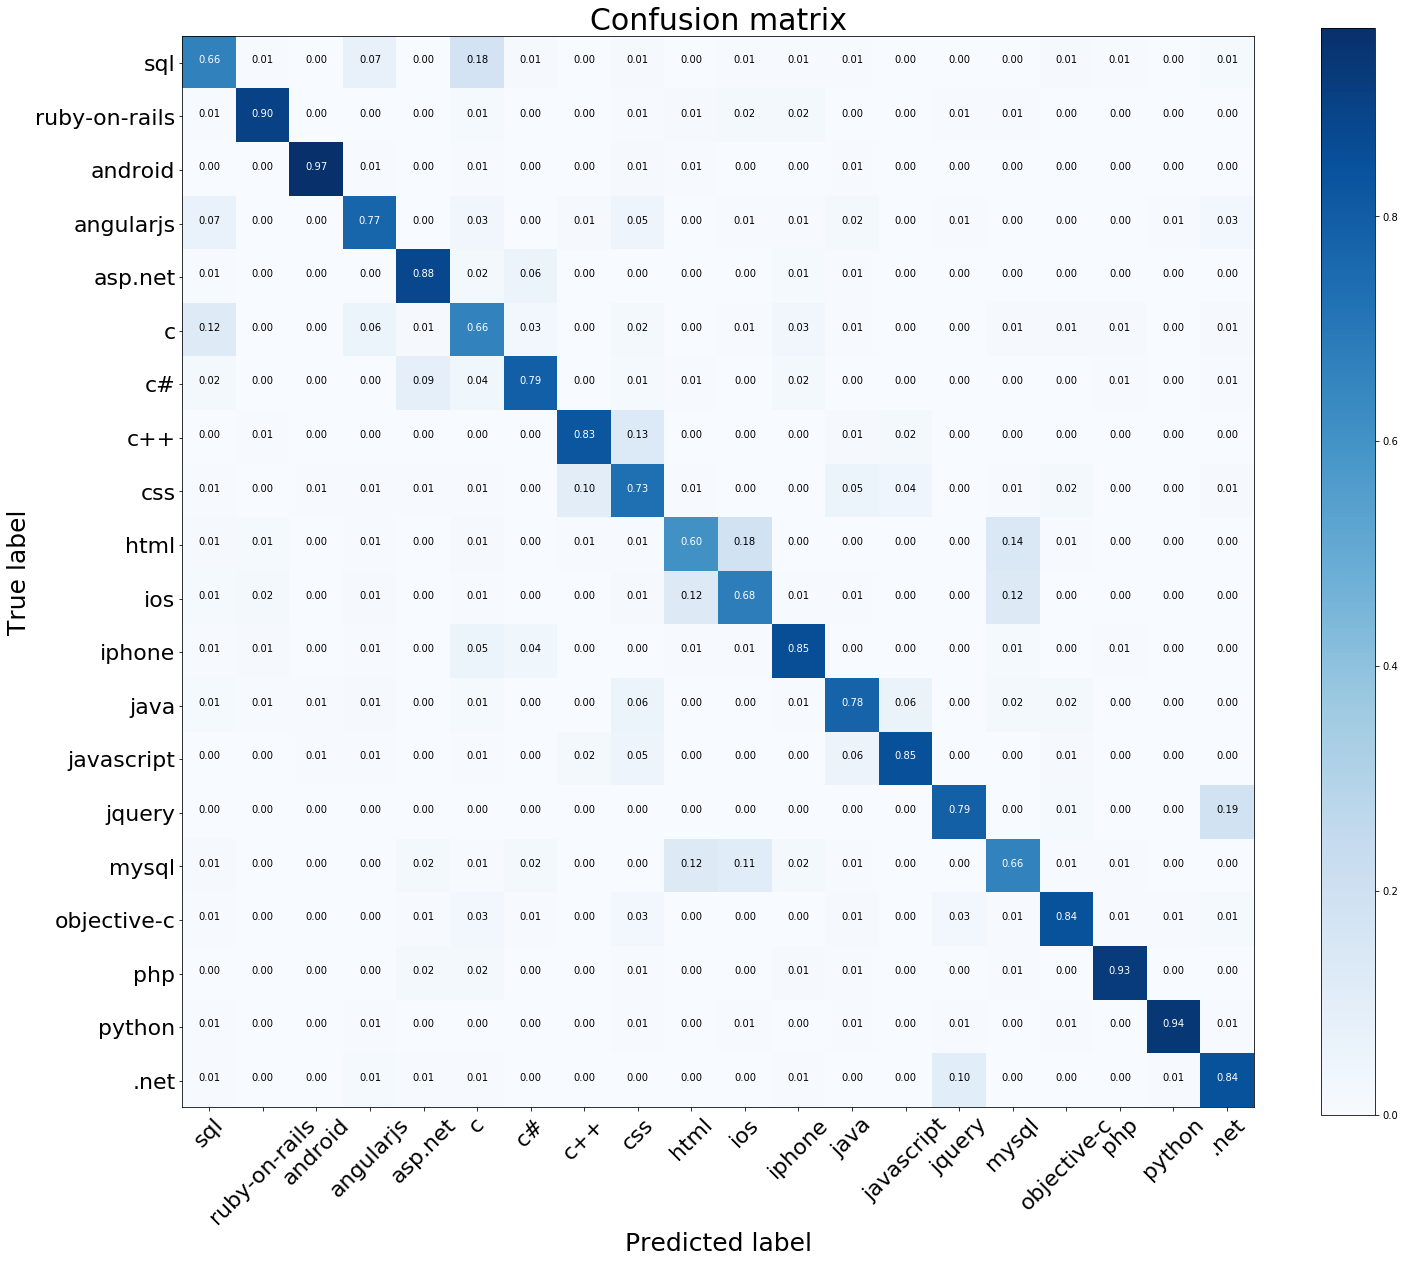

In [11]:
import numpy as np
from app.visualization import (plot_prediction_metrics,
                               create_clf_report,
                               plot_roc_curve,
                               plot_precision_recall_curve,
                               plot_confusion_matrix)
import matplotlib.pylab as plt

prediction_val_tf = model_tf.predict(model_data_tf['x_test'], batch_size=best_model_params['batch_size'])

# returns each entry result to the classification with the relevant probabilities
y_pred_processed_tf = np.array([np.argmax(val) for val in prediction_val_tf])
y_true_processed_tf = np.array([np.argmax(val) for val in model_data_tf['y_test']])

# If you want to see the OneVSAll ROC Curves of each class uncomment the below line
# plot_roc_curve(model_data_tf['y_test'], prediction_val_tf, Classes, 1)

# If you want to see the OneVSAll Precission Recall Curves of each class, comment out the below line
# plot_precision_recall_curve(model_data_tf['y_test'], prediction_val_tf, Classes , 1)

# If you want to get the Classification Report, comment out the below line
create_clf_report(y_true_processed_tf, y_pred_processed_tf, Classes)

# If you want to get the confusion matrix,comment out the below line
plot_confusion_matrix(y_true_processed_tf, y_pred_processed_tf, Classes)

## MLP classifier in Keras using standardized tf*idf features

In [12]:
# 70% Train & 30% Test
# 70% Train-Dev % 30* Train-Dev 
model_data_sdr_tf = preprocess_data(data, 'tags', 'post',
                                    input_ins='as_tf_idf',
                                    cv_split_full=0.2,
                                    cv_split_dev=0.125,
                                    standarize=True
                                    )

In [19]:
TALOS_SDR_TF_LOG_FILENAME = 'talos_sdr_tf_log_test'
#TALOS_SDR_TF_LOG_FILENAME = 'talos_sdr_tf_log'
talos_sdr_tf_log_pathname = os.path.join(TALOS_DIR, TALOS_SDR_TF_LOG_FILENAME)

tf_idf_sdr_model_config = tf_idf_model_config.copy()
tf_idf_sdr_model_config.update({
    'model_type': ['keras_sdr_tf_idf_model']
})

##### Production configuration
history_model_sdr_tf_idf = ta.Scan(model_data_sdr_tf['x_train'],
                                   model_data_sdr_tf['y_train'],
                                   x_val=model_data_sdr_tf['x_train_dev'],
                                   y_val=model_data_sdr_tf['y_train_dev'],
                                   model=load_model,
                                   params=tf_idf_sdr_model_config,
                                   grid_downsample=0.1,
                                   print_params=True,
                                   seed=(123),
                                   dataset_name=talos_sdr_tf_log_pathname
                                   )



  0%|          | 0/6 [00:00<?, ?it/s]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 15, 'batch_size': 64, 'model_type': 'keras_sdr_tf_idf_model'}



 17%|█▋        | 1/6 [01:01<05:05, 61.18s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 15, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}



 33%|███▎      | 2/6 [02:04<04:07, 61.93s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 20, 'batch_size': 64, 'model_type': 'keras_sdr_tf_idf_model'}



 50%|█████     | 3/6 [02:53<02:53, 57.79s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.6, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 15, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}



 67%|██████▋   | 4/6 [04:36<02:22, 71.43s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 20, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}



 83%|████████▎ | 5/6 [06:54<01:31, 91.41s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 20, 'batch_size': 64, 'model_type': 'keras_sdr_tf_idf_model'}



100%|██████████| 6/6 [07:44<00:00, 78.95s/it]

In [20]:
report_sdr_stf = ta.Reporting(history_model_sdr_tf_idf)
best_model_sdr_idx = report_sdr_stf.data['val_f1'].idxmax()
best_model_sdr_params = report_sdr_stf.data.loc[best_model_sdr_idx].to_dict()
best_model_sdr_params

{'round_epochs': 15,
 'val_loss': 0.5642155522108078,
 'val_f1': 0.7891465811729431,
 'val_categorical_accuracy': 0.821,
 'loss': 0.3266006512301309,
 'f1': 0.7714896503857204,
 'categorical_accuracy': 0.8943214285714286,
 'visualize_proccess': 'False',
 'first_neuron': 128,
 'activation': 'tanh',
 'dropout': 0.6,
 'number_of_hidden_layers': 1,
 'shapes': 'funnel',
 'epochs': 15,
 'batch_size': 32,
 'model_type': 'keras_sdr_tf_idf_model'}

In [21]:
model_sdr_tf_history, model_sdr_tf = load_model(model_data_sdr_tf['x_train'],
                                                model_data_sdr_tf['y_train'],
                                                model_data_sdr_tf['x_train_dev'],
                                                model_data_sdr_tf['y_train_dev'],
                                                best_model_sdr_params)

### Visualize Model History Scores

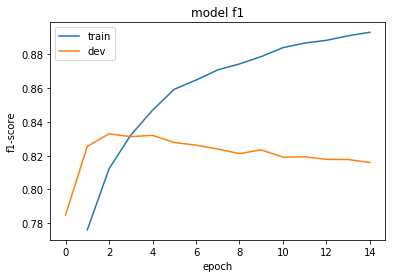

KeyError: 'val_'

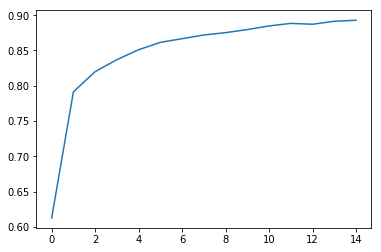

In [22]:
from app.visualization import plot_history_metrics
import matplotlib.pylab as plt
%matplotlib inline

plot_history_metrics(history_obj=model_sdr_tf_history)

### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [23]:
score_sdr_tf = model_sdr_tf.evaluate(model_data_sdr_tf['x_test'],
                                     model_data_sdr_tf['y_test'],
                                     batch_size=best_model_sdr_params['batch_size'],
                                     verbose=1)

print('\nTest f1: %.4f' % (score_sdr_tf[1]))
print('\nTest categorical accuracy: %.4f'% (score_sdr_tf[2]))

8000/8000 [==============================] - 0s 55us/step

Test f1: 0.8051

Test categorical accuracy: 0.7986


### Visualize Prediction Perfomance of **standardized** TF-IDF  model

--------------------------------------------------------------------------------
Accuracy Score: 79.86%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.673     0.642     0.657       400
           1      0.912     0.912     0.912       400
           2      0.982     0.960     0.971       400
           3      0.804     0.770     0.787       400
           4      0.840     0.880     0.860       400
           5      0.576     0.703     0.633       400
           6      0.839     0.780     0.808       400
           7      0.811     0.835     0.823       400
           8      0.644     0.710     0.675       400
           9      0.668     0.610     0.638       400
          10      0.677     0.698     0.687       400
          11      0.845     0.875     0.860       400
       

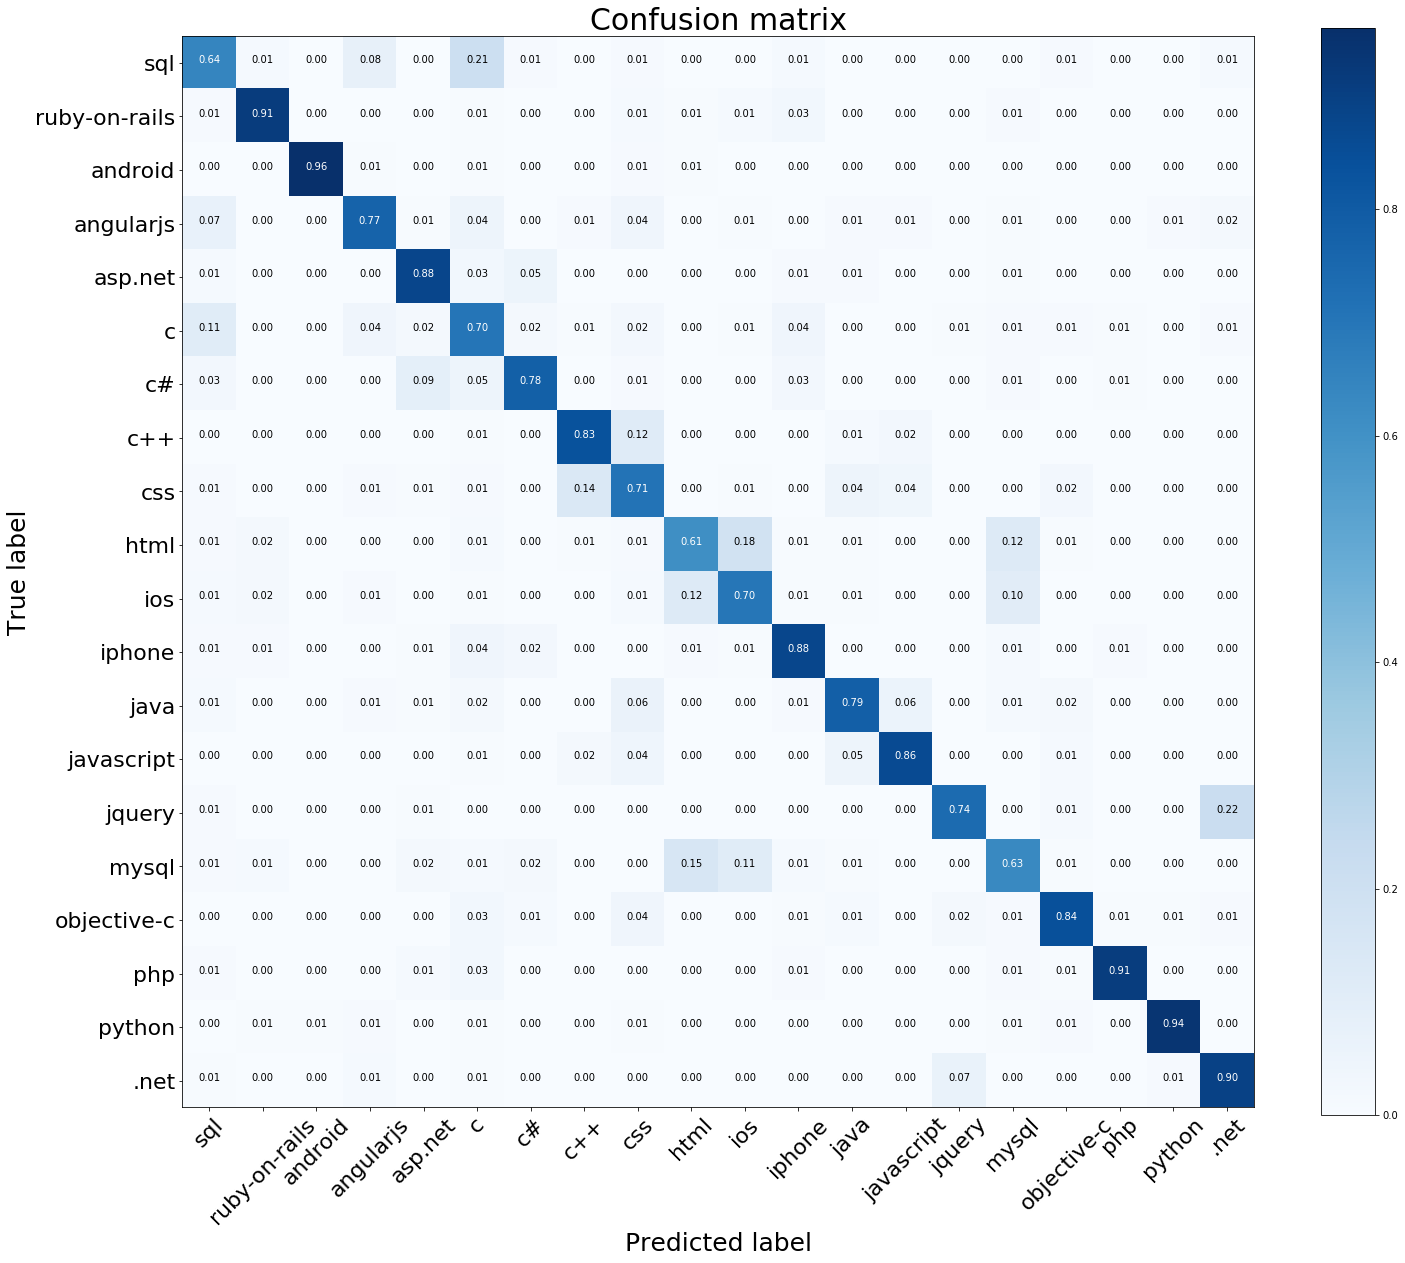

In [24]:
import numpy as np
from app.visualization import (plot_prediction_metrics,
                               create_clf_report,
                               plot_roc_curve,
                               plot_precision_recall_curve,
                               plot_confusion_matrix)
import matplotlib.pylab as plt

prediction_val_sdr_tf = model_sdr_tf.predict(model_data_sdr_tf['x_test'],
                                             batch_size=best_model_sdr_params['batch_size'])

# returns each entry result to the classification with the relevant probabilities
y_pred_processed_sdr_tf = np.array([np.argmax(val) for val in prediction_val_sdr_tf])
y_true_processed_sdr_tf = np.array([np.argmax(val) for val in model_data_sdr_tf['y_test']])

# If you want to get the Classification Report, comment out the below line
create_clf_report(y_true_processed_sdr_tf, y_pred_processed_sdr_tf , Classes)

# If you want to get the confusion matrix,comment out the below line
plot_confusion_matrix(y_true_processed_sdr_tf, y_pred_processed_sdr_tf , Classes)